In [154]:
import ast
import pandas as pd 
import timeit
import numpy as np 
from statistics import mean
import prophet
import pydeck as pdk
import os
import zipfile
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [155]:
#Extracts oversized files for execution
#Adds london_airbnb.html to gitignore automatically
files_extracted = ['./denver_airbnb.html','./london_airbnb.html']

#Extracts London AirBnb data, if not already extracted
destination_file = './Clean_Data/London_AirBNB_Data.csv'
if not os.path.exists(destination_file):
    file_to_unzip = './Clean_Data/London_AirBNB_Data.zip'
    extract_to_dir = './Clean_Data/'
    with zipfile.ZipFile(file_to_unzip, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
    files_extracted.append(destination_file)
    print(f"{file_to_unzip} extracted successfully")
else: print(f"{destination_file} already present.")


#Extracts London Starbucks data, if not already extracted
destination_file = './Clean_Data/London_Starbucks_Data.csv'
if not os.path.exists(destination_file):
    file_to_unzip = './Clean_Data/London_Starbucks_Data.zip'
    extract_to_dir = './Clean_Data/'
    with zipfile.ZipFile(file_to_unzip, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
    files_extracted.append(destination_file)
    print(f"{file_to_unzip} extracted successfully")
else: print(f"{destination_file} already present.")


#Extracts london_listings, if not already extracted
destination_file = './Raw_Data/london_listings.csv'
if not os.path.exists(destination_file):
    file_to_unzip = './Raw_Data/london_listings.zip'
    extract_to_dir = './Raw_Data/'
    with zipfile.ZipFile(file_to_unzip, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
    files_extracted.append(destination_file)
    print(f"{file_to_unzip} extracted successfully")
else: print(f"{destination_file} already present.")


#Opens .gitignore as read, checks .gitignore for presence of files
#Appends files that were extracted above and are not already present to .gitignore
with open('.gitignore', "r") as file:
    lines_for_gitignore = []
    lines = file.readlines()
    for file_name in files_extracted:
        file_in_gitignore = False
        for line in lines:
            if file_name.lstrip('./') in line:
                file_in_gitignore = True
                break
        if not file_in_gitignore:
            lines_for_gitignore.append(file_name)
        else: print(f"{file_name} already in .gitignore")
file.close()

#Opens .gitignore as append and writes each file from lines_for_gitignore
with open('.gitignore', 'a') as file:
    for file_name in lines_for_gitignore:
        file.write('\n'+file_name.lstrip('./'))
        print(f"Added {file_name} to .gitignore")
    

./Clean_Data/London_AirBNB_Data.csv already present.
./Clean_Data/London_Starbucks_Data.csv already present.
./Raw_Data/london_listings.csv already present.
./denver_airbnb.html already in .gitignore
./london_airbnb.html already in .gitignore


# Imports

In [156]:
#Import two data-sets
starbucks_df = pd.read_csv('./Clean_Data/Starbucks_Data.csv')
airbnb_df = pd.read_csv('./Clean_Data/AirBNB_Data.csv')
#Convert List columns stored as strings to lists
starbucks_df['airbnb_distances'] = starbucks_df['airbnb_distances'].apply(ast.literal_eval)
airbnb_df['starbucks_distances'] = airbnb_df['starbucks_distances'].apply(ast.literal_eval)
#Convert Date columns to Datetime
airbnb_df['first_review'] = pd.to_datetime(airbnb_df['first_review'])
airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'])
#Preview to verify
display(starbucks_df.head(1))
display(starbucks_df.info())

display(airbnb_df.head(1))
display(airbnb_df.info())

,store_id,index,countryCode,ownershipTypeCode,latitude,longitude,city,countrySubdivisionCode,postalCode,distance_to_den,airbnb_distances
0,1743,3739,US,CO,39.65278,-104.928197,Denver,CO,80222,6.65,"[8.77, 8.31, 7.12, 7.1, 7.03, 5.96, 6.87, 9.22..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   store_id                303 non-null    int64  
 1   index                   303 non-null    int64  
 2   countryCode             303 non-null    object 
 3   ownershipTypeCode       303 non-null    object 
 4   latitude                303 non-null    float64
 5   longitude               303 non-null    float64
 6   city                    303 non-null    object 
 7   countrySubdivisionCode  303 non-null    object 
 8   postalCode              303 non-null    int64  
 9   distance_to_den         303 non-null    float64
 10  airbnb_distances        303 non-null    object 
dtypes: float64(3), int64(3), object(5)
memory usage: 26.2+ KB


None

,id,description,neighborhood_overview,host_neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,bathroom_count,starbucks_distances,starbucks_review_mentions
0,360,Enjoy the famous Colorado weather and unplug i...,The cottage is located in the center of Lower ...,Highland,Highland,39.766415,-105.002098,Entire guesthouse,Entire home/apt,3,...,5.0,5.0,5.0,4.91,f,2,2.87,1.0,"[8.77, 9.04, 9.19, 7.71, 7.6, 8.33, 7.4, 9.44,...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5367 entries, 0 to 5366
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              5367 non-null   int64         
 1   description                     5367 non-null   object        
 2   neighborhood_overview           5367 non-null   object        
 3   host_neighbourhood              5367 non-null   object        
 4   neighbourhood_cleansed          5367 non-null   object        
 5   latitude                        5367 non-null   float64       
 6   longitude                       5367 non-null   float64       
 7   property_type                   5367 non-null   object        
 8   room_type                       5367 non-null   object        
 9   accommodates                    5367 non-null   int64         
 10  bathrooms_text                  5367 non-null   object        
 11  bedr

None

# Data Analytics

In [157]:
#Manually assigned distances of interest
bins = [.1, .25, .5, 1, 2, 5]
#Define a function that loops through each 'bin' (not technically correct)
#and counts starbucks within that range, then populate a column with that count
#for future plots
def airbnb_to_starbucks():
    for bin in bins:
        def nested_bin(row):
            dist_to_sb_list = row['starbucks_distances']
            sb_within_range = [x for x in dist_to_sb_list if x < bin]
            return len(sb_within_range)
        column_name = f"SB_within_{bin}_miles"
        airbnb_df[column_name] = airbnb_df.apply(nested_bin, axis=1)
# Run the function
airbnb_to_starbucks()
# Do it again for starbucks
def starbucks_to_airbnb():
    for bin in bins:
        def nested_bin(row):
            dist_to_bnb_list = row['airbnb_distances']
            bnb_within_range = [x for x in dist_to_bnb_list if x < bin]
            return len(bnb_within_range)
        column_name = f"Airbnb_within_{bin}_miles"
        starbucks_df[column_name] = starbucks_df.apply(nested_bin, axis=1)
starbucks_to_airbnb()

In [158]:
#calculate the average distance to the nearest 5 starbucks or bnbs
def mean_dist_nearest_5_sb(row):
    dist_list = row['starbucks_distances']
    dist_list.sort()
    return round(mean(dist_list[:5]),2)

def mean_dist_nearest_5_bnb(row):
    dist_list = row['airbnb_distances']
    dist_list.sort()
    return round(mean(dist_list[:5]),2)

airbnb_df['nearest_5_avg'] = airbnb_df.apply(mean_dist_nearest_5_sb, axis=1)
starbucks_df['nearest_5_avg'] = starbucks_df.apply(mean_dist_nearest_5_bnb, axis=1)

In [159]:
#Add a column for "price per occupant" 
airbnb_df['price_per_occupant'] = round(airbnb_df['price']/airbnb_df['accommodates'],2)

In [160]:
first_review_df = airbnb_df.copy()
first_review_df.dropna(how='any', inplace=True)
first_review_df.set_index('first_review',inplace=True)
first_review_df_agg = first_review_df.groupby([first_review_df.index.year, first_review_df.index.month])
first_review_df_agg = first_review_df_agg['id'].count().to_frame()
first_review_df_agg.columns = ['Total_New_Airbnbs']
first_review_df_agg['dateseries'] = pd.to_datetime(first_review_df_agg.index.get_level_values(0).astype(str)+'-'+first_review_df_agg.index.get_level_values(1).astype(str))
first_review_df_agg.set_index('dateseries',inplace=True)
first_review_df_agg.reset_index(inplace=True)
first_review_df_agg.columns = ['ds','y']
# first_review_df_agg.to_csv('./Clean_Data/DateSeries_Prophet.csv')


In [161]:
def total_bnbs(row):
    date = row['ds']
    total = first_review_df_agg.loc[first_review_df_agg['ds'] <= date]['y'].sum()
    return total

first_review_df_agg['total_airbnbs'] = first_review_df_agg.apply(total_bnbs, axis=1)

total_bnb_df = first_review_df_agg[['ds','total_airbnbs']].rename(columns={'total_airbnbs':'y'})
new_bnb_df = first_review_df_agg[['ds','y']]

19:13:55 - cmdstanpy - INFO - Chain [1] start processing


19:13:55 - cmdstanpy - INFO - Chain [1] done processing
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this

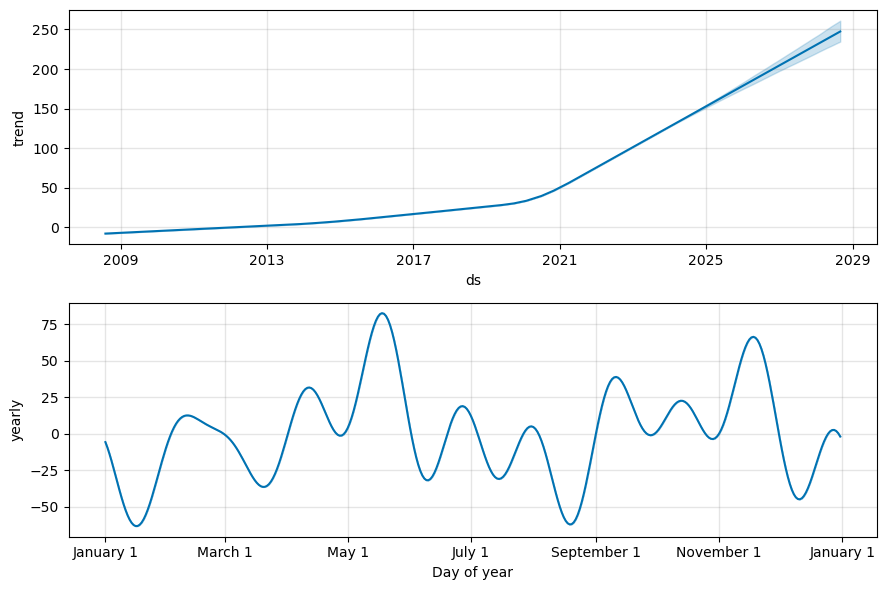

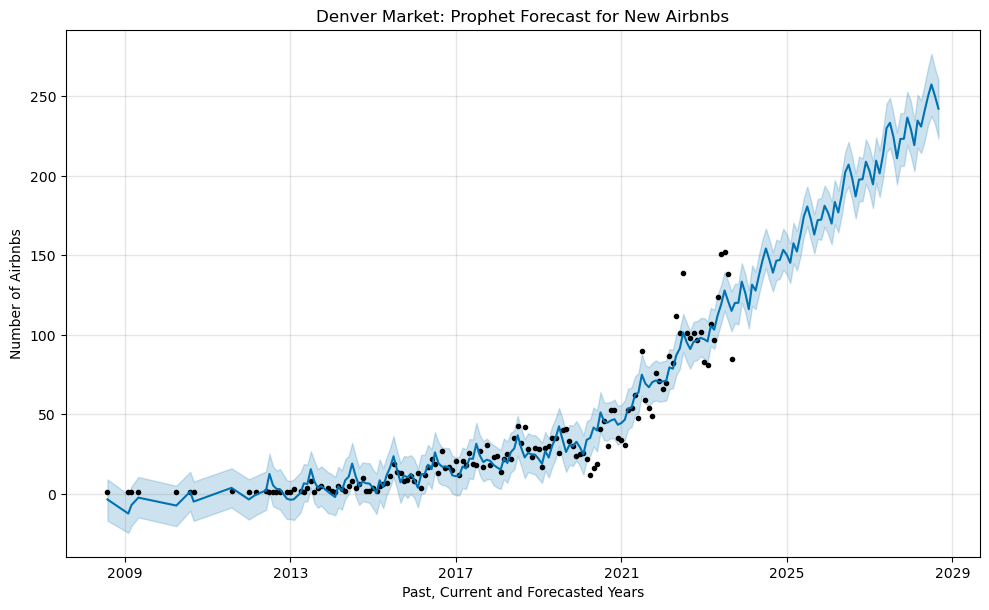

In [162]:
#model and plot for new airbnbs
m = prophet.Prophet()
m.fit(new_bnb_df)
future_df = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future_df)
m.plot_components(forecast)

fig=m.plot(forecast)
plt.title("Denver Market: Prophet Forecast for New Airbnbs")
plt.xlabel("Past, Current and Forecasted Years")
plt.ylabel("Number of Airbnbs")
plt.show()


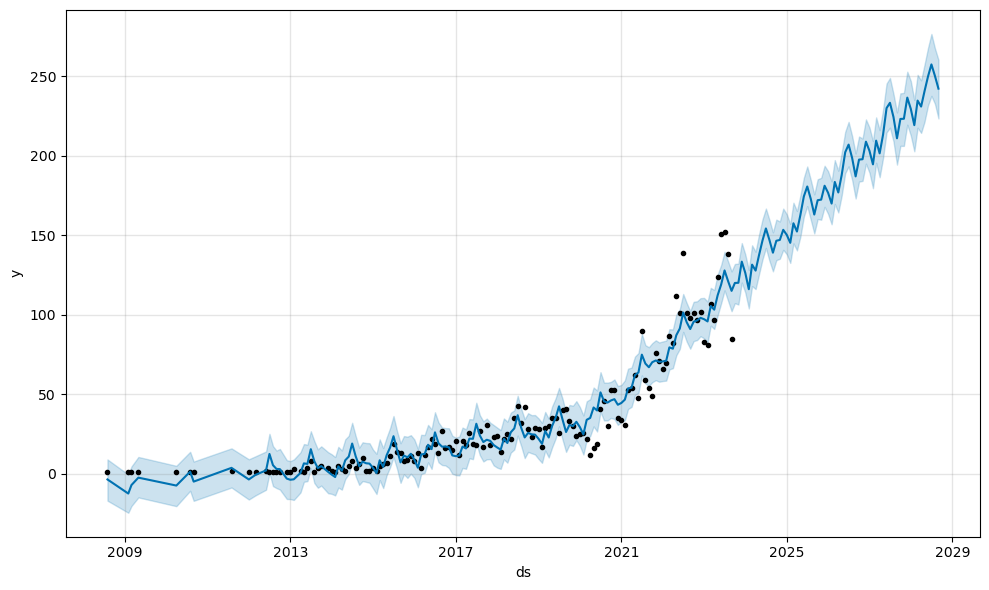

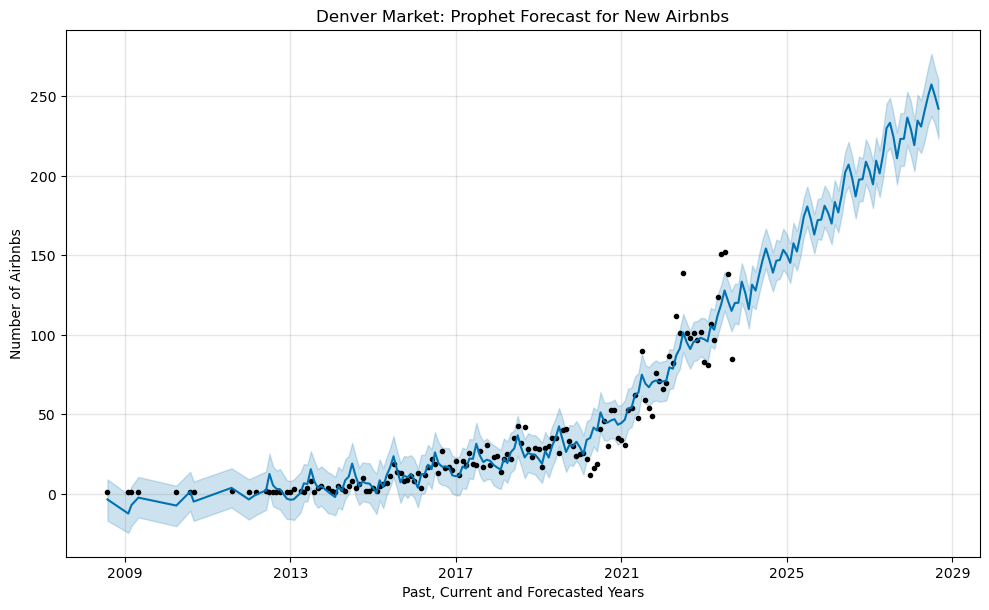

In [163]:
m.plot(forecast)
fig=m.plot(forecast)
plt.title("Denver Market: Prophet Forecast for New Airbnbs")
plt.xlabel("Past, Current and Forecasted Years")
plt.ylabel("Number of Airbnbs")
plt.show()

19:13:56 - cmdstanpy - INFO - Chain [1] start processing


19:13:56 - cmdstanpy - INFO - Chain [1] done processing
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/christinekanouff/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this

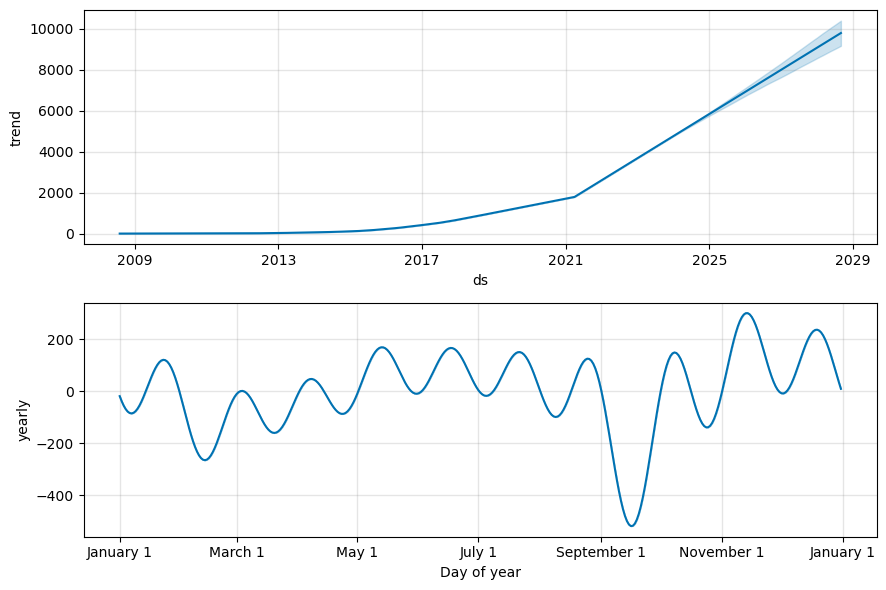

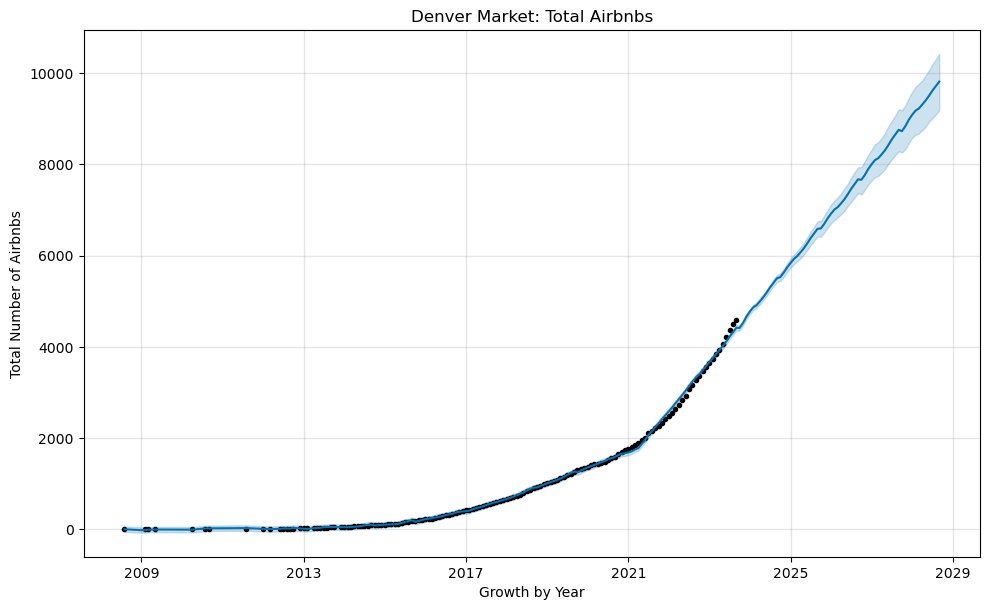

In [164]:
#model and plot for total airbnbs
m2 = prophet.Prophet()
m2.fit(total_bnb_df)
future_df2 = m2.make_future_dataframe(periods=60, freq='M')
forecast2 = m2.predict(future_df2)
m2.plot_components(forecast2)
fig=m2.plot(forecast2)
plt.title("Denver Market: Total Airbnbs")
plt.xlabel("Growth by Year")
plt.ylabel("Total Number of Airbnbs")
plt.show()

# Visualizations

### Reviews with respect to the number of starbucks within 0.5 miles (distance may change based on group-by line)

SB_within_0.5_miles
0     2457
1     1297
2      389
3       99
4       84
5       37
6       42
7        7
8       19
9       60
10      65
11      25
12       8
Name: review_scores_rating, dtype: int64

<Axes: xlabel='SB_within_0.5_miles'>

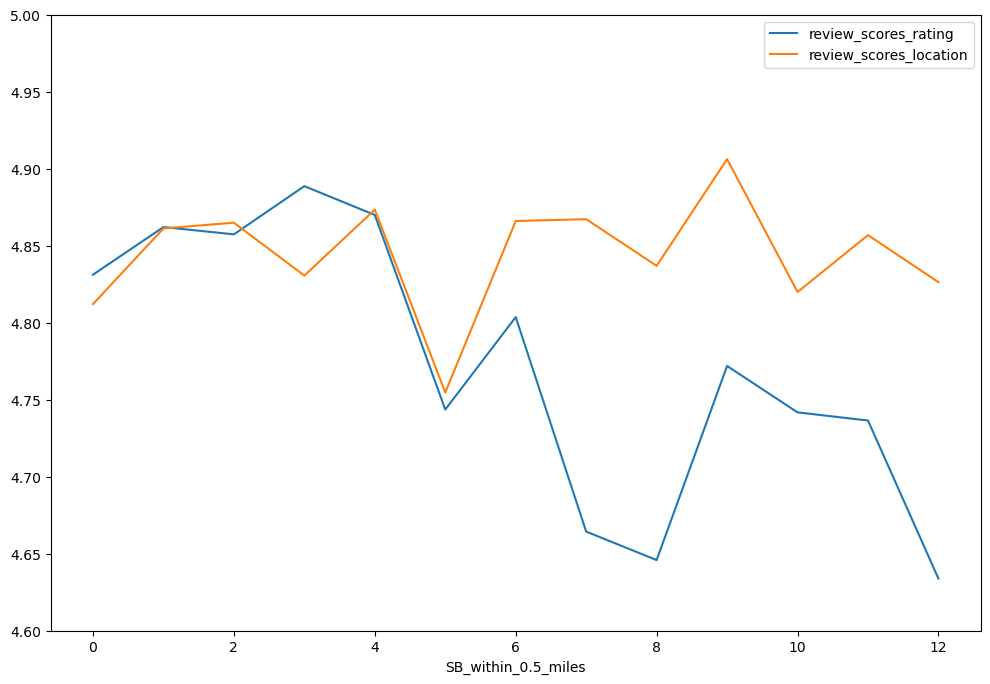

In [165]:
#Aggregate reviews by the number of SB within X miles
airbnb_df_reviewed_only = airbnb_df.loc[airbnb_df['review_scores_rating'] != -1]
aggregate_bnb_df = airbnb_df_reviewed_only.groupby(by=['SB_within_0.5_miles'])
agg_bnb_df_mean = aggregate_bnb_df[['price', 'review_scores_rating','review_scores_location']].mean()
display(aggregate_bnb_df['review_scores_rating'].count())
agg_bnb_df_mean[['review_scores_rating','review_scores_location']].plot(figsize=(12,8), ylim=(4.6,5))

### Not very helpful scatter-plot of reviews vs average distance to nearest 5 SB

<Axes: xlabel='nearest_5_avg', ylabel='review_scores_rating'>

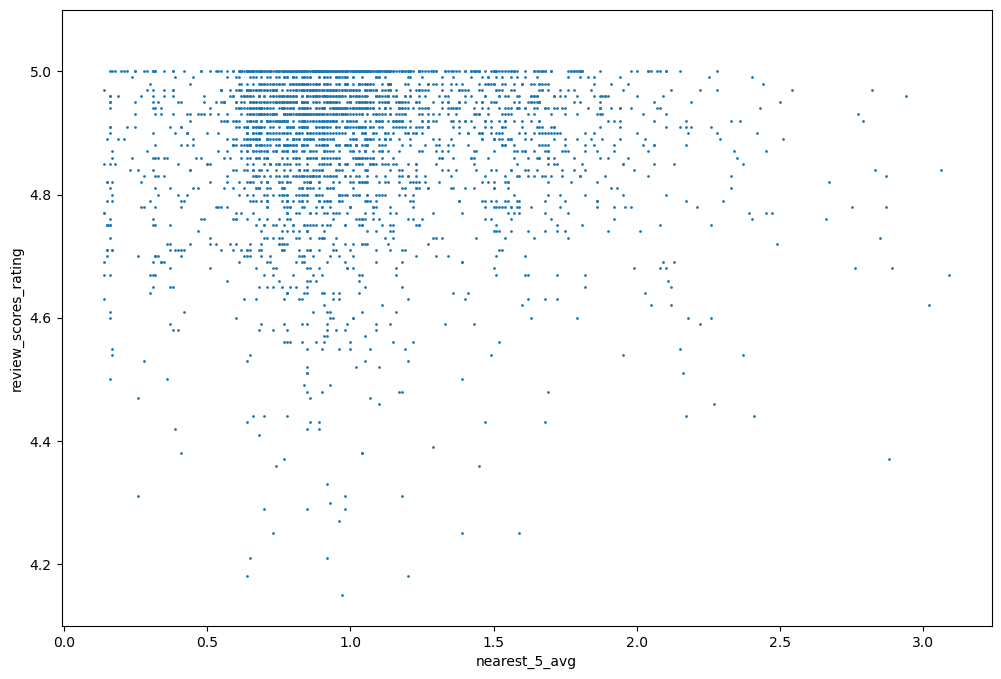

In [166]:
airbnb_df.loc[(airbnb_df['review_scores_rating'] != -1) & (airbnb_df['number_of_reviews'] > 10)]\
    .plot(x='nearest_5_avg', y='review_scores_rating', kind='scatter', ylim=(4.1, 5.1), figsize=(12,8), s=1)

### Chart Depicting Reviews vs mileage to the nearest 5 starbucks

/var/folders/rp/ncflq_412jl43pyy15l7scc40000gn/T/ipykernel_47939/332994158.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_near5_airbnb = airbnb_df.loc[airbnb_df['review_scores_rating'] != -1].groupby('nearest_5_distance_bins')


Text(0.5, 1.0, 'Denver: Airbnb Reviews by Starbucks Location')

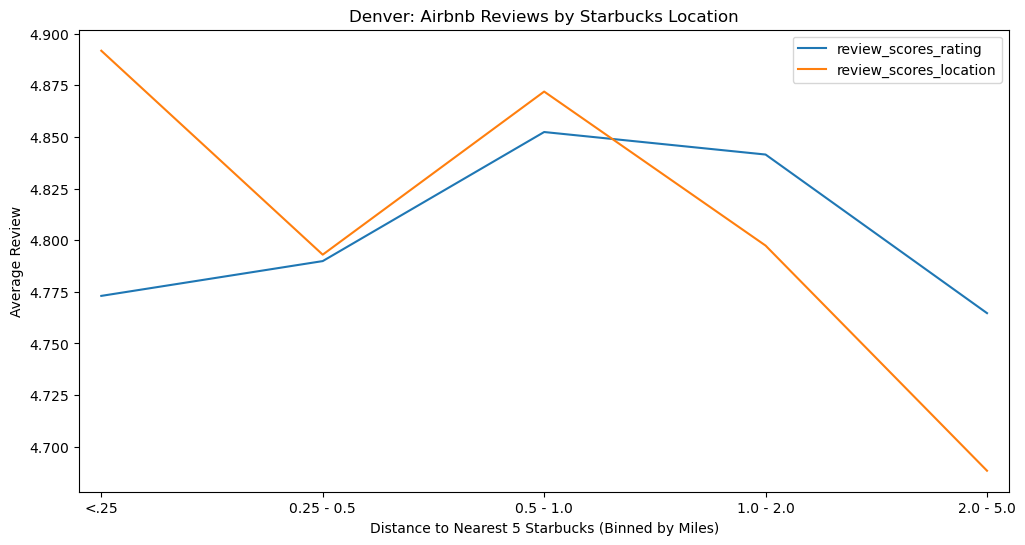

In [167]:
#actual binning of the data by nearest_5_avg
nearest_5_bins = [0, 0.25, 0.5, 1, 2, 5]
labels = [1,2,3,4,5]
airbnb_df['nearest_5_distance_bins']=pd.cut(airbnb_df['nearest_5_avg'], bins=nearest_5_bins, labels=labels)
grouped_near5_airbnb = airbnb_df.loc[airbnb_df['review_scores_rating'] != -1].groupby('nearest_5_distance_bins')
plt = grouped_near5_airbnb[['review_scores_rating', 'review_scores_location']].mean().plot(figsize=(12,6))
plt.set_xticks([0,1,2,3,4])
plt.set_xlim((-.1,4.1))
plt.set_xticklabels(['<.25','0.25 - 0.5','0.5 - 1.0','1.0 - 2.0','2.0 - 5.0'])
plt.set_xlabel("Distance to Nearest 5 Starbucks (Binned by Miles)")
plt.set_ylabel("Average Review")
plt.set_title("Denver: Airbnb Reviews by Starbucks Location")

### Average Price with respect to distance to nearest 5 starbucks (same bins as above)

Text(0.5, 1.0, 'Denver: Price Per Occupant Versus Proximity to Starbucks')

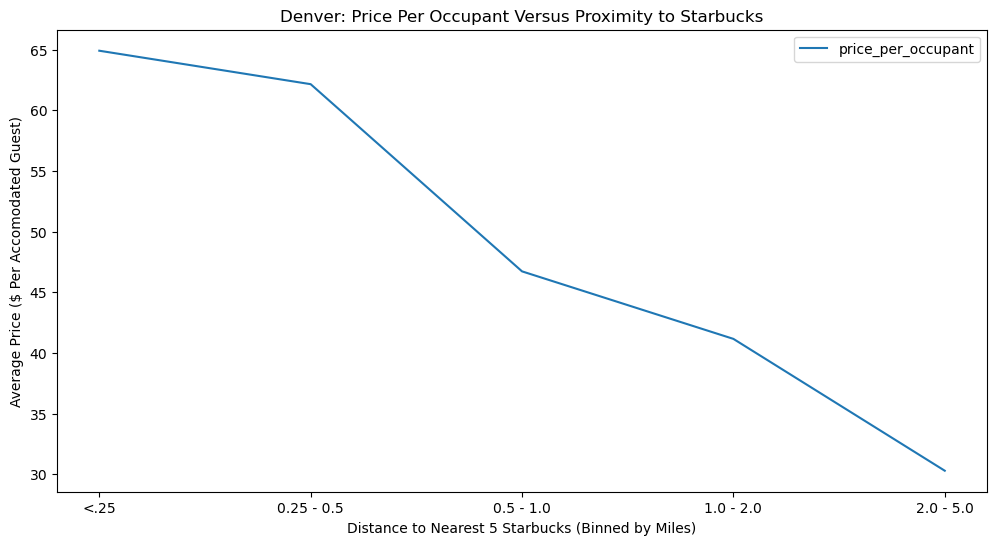

In [168]:
plt2 = grouped_near5_airbnb[['price_per_occupant']].mean().plot(figsize=(12,6))
plt2.set_xticks([0,1,2,3,4])
plt2.set_xticklabels(['<.25','0.25 - 0.5','0.5 - 1.0','1.0 - 2.0','2.0 - 5.0'])
plt2.set_xlabel("Distance to Nearest 5 Starbucks (Binned by Miles)") #CK Make Changes to Both Markets
plt2.set_ylabel("Average Price ($ Per Accomodated Guest)")
plt2.set_title("Denver: Price Per Occupant Versus Proximity to Starbucks")

# Testing that supported decisions while writing

In [169]:
#speed testing list comprehension vs. numpy eval:
def numpy_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    numpy_array = np.array(data_list)
    nearby_distances = numpy_array[numpy_array < 1]
    nearby_distances = np.sort(nearby_distances)
    nearby_count = len(nearby_distances)
    return(nearby_count,nearby_distances)

time_taken_numpy = timeit.timeit(numpy_speed, number=5000)

def list_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    keep_list = [x for x in data_list if x < 1]
    keep_list.sort()
    nearby_count = len(keep_list)
    return(nearby_count,keep_list)

time_taken_list = timeit.timeit(list_speed, number=1000)

print(f"numpy: {time_taken_numpy}")
print(f"list comprehension: {time_taken_list}")

#list comprehension was consistently ~5-10% faster

numpy: 0.5794226248981431
list comprehension: 0.07663095905445516


In [170]:
#Prepping Data into lat and long bins for geographical plotting
pydeck_df = airbnb_df[['latitude','longitude']].copy()
lat_min = pydeck_df['latitude'].min()
lat_max = pydeck_df['latitude'].max()
long_min = pydeck_df['longitude'].min()
long_max = pydeck_df['longitude'].max()
bin_count = 30

#Generate Bin Limits
lat_step = round((lat_max-lat_min)/bin_count,3)
long_step = round((long_max-long_min)/bin_count,3)
lat_bins = np.arange(lat_min,lat_max,lat_step)
long_bins = np.arange(long_min,long_max,long_step)

#The following solves some rounding errors that didn't bin data
lat_bins[0] -= .01
lat_bins[-1] += .01
long_bins[0] -= .01
long_bins[-1] += .01

#Generate Grid Centers
lat_centers = []
for index, item in enumerate(lat_bins):
    try:
        coord_center = (lat_bins[index] + lat_bins[index+1])/2
        lat_centers.append(coord_center)
    except IndexError:
        pass

long_centers = []
for index, item in enumerate(lat_bins):
    try:
        coord_center = (long_bins[index] + long_bins[index+1])/2
        long_centers.append(coord_center)
    except IndexError:
        pass
#Populate bins
pydeck_df['lat_bins'] = pd.cut(pydeck_df['latitude'], bins=lat_bins, labels=range(len(lat_bins)-1))
pydeck_df['long_bins'] = pd.cut(pydeck_df['longitude'], bins=long_bins, labels=range(len(long_bins)-1))

#Generate Pixels
pixel_pairs = []
for latitude in lat_centers:
    for longitude in long_centers:
        pair = [latitude, longitude]
        pixel_pairs.append(pair)

index_pairs = []
for x in range(len(lat_centers)):
    for y in range(len(long_centers)):
        pair = [x,y]
        index_pairs.append(pair)
pydeck_summary_df = pd.DataFrame({'xy_pair':index_pairs,'latlong_pair':pixel_pairs})
def pixel_counter(row):
    bin = row['xy_pair']
    count = len(pydeck_df.loc[(pydeck_df['lat_bins'] == bin[0]) & (pydeck_df['long_bins'] == bin[1])])
    return count

pydeck_summary_df['AirBnb_Count'] = pydeck_summary_df.apply(pixel_counter, axis=1)
pydeck_summary_df['lat'] = pydeck_summary_df['latlong_pair'].apply(lambda x: x[0] if x else None)
pydeck_summary_df['long'] = pydeck_summary_df['latlong_pair'].apply(lambda x: x[1] if x else None)
pydeck_summary_df = pydeck_summary_df.loc[pydeck_summary_df['AirBnb_Count'] > 0 ]

In [171]:
pydeck_summary_df

,xy_pair,latlong_pair,AirBnb_Count,lat,long
2,"[0, 2]","[39.61453961309246, -105.0609635851113]",1,39.61454,-105.060964
29,"[1, 0]","[39.627539613092466, -105.09396358511128]",2,39.62754,-105.093964
42,"[1, 13]","[39.627539613092466, -104.90696358511133]",3,39.62754,-104.906964
58,"[2, 0]","[39.63553961309246, -105.09396358511128]",1,39.63554,-105.093964
61,"[2, 3]","[39.63553961309246, -105.04696358511129]",1,39.63554,-105.046964
...,...,...,...,...,...
711,"[24, 15]","[39.81153961309252, -104.87896358511134]",9,39.81154,-104.878964
712,"[24, 16]","[39.81153961309252, -104.86496358511135]",2,39.81154,-104.864964
718,"[24, 22]","[39.81153961309252, -104.78096358511138]",4,39.81154,-104.780964
719,"[24, 23]","[39.81153961309252, -104.76696358511137]",9,39.81154,-104.766964


In [172]:
#speed testing list comprehension vs. numpy eval:
def numpy_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    numpy_array = np.array(data_list)
    nearby_distances = numpy_array[numpy_array < 1]
    nearby_distances = np.sort(nearby_distances)
    nearby_count = len(nearby_distances)
    return(nearby_count,nearby_distances)

time_taken_numpy = timeit.timeit(numpy_speed, number=5000)

def list_speed():
    data_list = starbucks_df['airbnb_distances'][0]
    keep_list = [x for x in data_list if x < 1]
    keep_list.sort()
    nearby_count = len(keep_list)
    return(nearby_count,keep_list)

time_taken_list = timeit.timeit(list_speed, number=1000)

print(f"numpy: {time_taken_numpy}")
print(f"list comprehension: {time_taken_list}")

#list comprehension was consistently ~5-10% faster

numpy: 0.5777922500856221
list comprehension: 0.07705750002060086


In [173]:
#Learning how to use pydeck
# Build the map layer:    
airbnbs = pdk.Layer(type='ColumnLayer',
                  data=pydeck_summary_df,
                  opacity=0.3 ,
                  get_position=['long','lat'],
                  get_elevation='AirBnb_Count',
                  auto_highlight=True,
                  elevation_scale=15,
                  pickable=True,
                  get_fill_color=['AirBnb_Count', 130],
                  coverage=12/(bin_count))

starbucks = pdk.Layer(
    "HeatmapLayer",
    data=starbucks_df,
    opacity=0.8,
    get_position=["longitude", "latitude"],
    threshold=0.75,
    aggregation=pdk.types.String("SUM"),
    get_weight=4,
    pickable=True,
)

# Set the view parameters:
view_state = pdk.ViewState(longitude=pydeck_summary_df['long'].mean(), 
                           latitude=pydeck_summary_df['lat'].mean(),
                           zoom=10,
                           min_zoom=9,
                           max_zoom=16,
                           pitch=30.0,
                           bearing=45)

# Render the map:
r = pdk.Deck(layers=[airbnbs, starbucks], initial_view_state=view_state, map_style=pdk.map_styles.DARK)
r.to_html('denver_airbnb.html')
clear_output(wait=False)

In [174]:
import zipfile
import os

In [175]:
# File paths
file_to_zip = './denver_airbnb.html'
zip_file_name = 'denver_map.zip'

# Create a new zip file
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(file_to_zip, arcname='file.txt')

print("File zipped successfully")


File zipped successfully
